# Importing

In [1]:
# Import libraries/packages

# The basics
import numpy as np
import pandas as pd
import random
import os

# Animations / visualizations
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import seaborn as sns
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
import plotly.graph_objects as go
!pip install -U kaleido
import kaleido

# ML modeling & evaluation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, brier_score_loss, classification_report
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import statsmodels.api as sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 15.7 MB/s eta 0:00:00


In [2]:
# view file directory
for dirname, _, filenames in os.walk('/kaggle/input/nfl-big-data-bowl-2024'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# concatenate tracking files into one csv
tracking_list = [pd.read_csv(os.path.join(dirname, f"tracking_week_{week_number}.csv")) for week_number in range(1, 10)]
tracking = pd.concat(tracking_list, ignore_index=True)

/kaggle/input/nfl-big-data-bowl-2024/players.csv
/kaggle/input/nfl-big-data-bowl-2024/tracking_week_7.csv
/kaggle/input/nfl-big-data-bowl-2024/tracking_week_9.csv
/kaggle/input/nfl-big-data-bowl-2024/tracking_week_6.csv
/kaggle/input/nfl-big-data-bowl-2024/games.csv
/kaggle/input/nfl-big-data-bowl-2024/tracking_week_8.csv
/kaggle/input/nfl-big-data-bowl-2024/tracking_week_4.csv
/kaggle/input/nfl-big-data-bowl-2024/tracking_week_3.csv
/kaggle/input/nfl-big-data-bowl-2024/tackles.csv
/kaggle/input/nfl-big-data-bowl-2024/tracking_week_5.csv
/kaggle/input/nfl-big-data-bowl-2024/tracking_week_1.csv
/kaggle/input/nfl-big-data-bowl-2024/plays.csv
/kaggle/input/nfl-big-data-bowl-2024/tracking_week_2.csv


In [3]:
# load in other provided data
plays = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2024/plays.csv')
players = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2024/players.csv')
games = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2024/games.csv')
tackles = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2024/tackles.csv')

In [4]:
# Load PFR data; Prior season stats will be used to train model. Current season rankings can be used to compare against our final rankings.
# 2021 seasonal defensive stats
pff_stats_2021 = pd.read_csv('/kaggle/input/pff-per-game-defensive-stats-2021/pff_per_game_def_2021.csv')
# 2022 seasonal defensive stats
pff_stats_2022 = pd.read_csv('/kaggle/input/pff-per-game-defensive-stats-2022/pff_per_game_def_2022.csv')

# Data Cleansing

In [5]:
# Clean the 2021 PFR features to be used in model
pff_stats_2021_cleaned = pff_stats_2021[['Rk', 'Data Bowl Name', 'Age', 'Pos', 'G', 'GS', 'Comb', 'Solo', 'Ast', 'TFL']]
columns_to_fill = ['G', 'GS', 'Comb', 'Solo', 'Ast', 'TFL']
pff_stats_2021_cleaned = pff_stats_2021_cleaned.copy()
pff_stats_2021_cleaned[columns_to_fill] = pff_stats_2021_cleaned[columns_to_fill].fillna(0)
pff_stats_2021_cleaned['displayName'] = pff_stats_2021_cleaned['Data Bowl Name']
pff_stats_2021_cleaned.drop(columns=['Data Bowl Name'], inplace=True)

In [6]:
# Merge in prior season metrics.
# 'displayName' used as key. Not a perfect key, but very close.
# I added 'displayName' manually to the PFR dataset and adjusted names as needed to create an accurate mapping.
# Since we only look at linebackers for this project the manual fixes were rather simple.
players = players.merge(pff_stats_2021_cleaned[['Pos', 'G', 'GS', 'Comb', 'Solo', 'Ast', 'TFL', 'displayName']], on=['displayName'], how='left')
# If no stats available from prior season, replace empty stats with 0.
players = players.fillna(0)

In [7]:
# Convert 'height' to inches. i.e. we prefer 72 inches instead of 6-0 for modeling purposes.
def convert_height(height):
    feet, inches = map(int, height.split('-'))
    return feet * 12 + inches
players['height_inches'] = players['height'].apply(convert_height)

In [8]:
# For modeling purposes, we only want to train our model with full plays,
# i.e. it starts with a ball snap and ends with an appropriate event.

# identify plays with ball snap events
ball_snap_events = tracking[tracking['event'] == 'ball_snap']
plays_with_snap = ball_snap_events[['gameId', 'playId']].drop_duplicates()
# filter out plays with no ball snap events
plays_model = plays.merge(plays_with_snap, on=['gameId', 'playId'], how='inner')

# Let's see what the final events were for all the plays in our tracking dataset.
tracking_events = tracking.dropna(subset=['event'])
tracking_last_events = tracking_events.groupby(['gameId', 'playId']).agg(
    frame_last_event=('frameId', 'max'),
    lastEvent=('event', 'last')
).reset_index()
event_counts = tracking_last_events['lastEvent'].value_counts()
print(event_counts)
# For modeling purposes, let's remove the uncommon endings.
# Also, let's remove fumbles since they tend to be chaotic.
# This ensures our model is trained on typical behaviors.
tracking_last_events = tracking_last_events[tracking_last_events['lastEvent'].isin(['tackle','out_of_bounds','touchdown','qb_slide'])]
plays_model = pd.merge(plays_model, tracking_last_events, on=['gameId', 'playId'], how='inner')
# Filter out penalty plays. These can also cause atypical behavior for players
plays_model = plays_model[plays_model['foulName1'].isna()]
# All remaining plays have a start and finish that will be friendly to our model

# Our play data has been cleaned, so let's filter out unnecessary plays from the tracking data.
tracking_cleaned = tracking.merge(plays_model[['gameId', 'playId']], on=['gameId', 'playId'], how='inner')
# Drop some unused fields for optimization purposes
tracking_cleaned = tracking_cleaned.drop(columns=['time','jerseyNumber'])

lastEvent
tackle                       10017
out_of_bounds                 1806
touchdown                      413
qb_slide                       136
fumble                          88
autoevent_passinterrupted        7
fumble_defense_recovered         4
fumble_offense_recovered         3
safety                           3
first_contact                    3
autoevent_passforward            2
pass_outcome_caught              2
handoff                          1
penalty_flag                     1
Name: count, dtype: int64


In [9]:
# Filter out any frames prior to a ball snap and after the last event.
# Identify when the ball is snapped
ball_snap_events = tracking_cleaned[tracking_cleaned['event'] == 'ball_snap']
snap_frames = ball_snap_events.groupby(['gameId', 'playId'])['frameId'].max().reset_index()
snap_frames.rename(columns={'frameId': 'ball_snap_frame'}, inplace=True)
tracking_cleaned = tracking_cleaned.merge(snap_frames, on=['gameId', 'playId'], how='left')

# Identify when the play ends
end_events = tracking_cleaned[~tracking_cleaned['event'].isna()]
end_frames = end_events.groupby(['gameId', 'playId'])['frameId'].max().reset_index()
end_frames.rename(columns={'frameId': 'end_frame'}, inplace=True)
tracking_cleaned = tracking_cleaned.merge(end_frames, on=['gameId', 'playId'], how='left')

# Remove any frames before the snap and after end of play
tracking_cleaned = tracking_cleaned[(tracking_cleaned['frameId'] >= tracking_cleaned['ball_snap_frame']) & (tracking_cleaned['frameId'] <= tracking_cleaned['end_frame'])]

# Feature Engineering

In [10]:
# Calculate distance to closest sideline
tracking_cleaned['dist_to_sideline'] = np.minimum(53.3 - tracking_cleaned['y'], tracking_cleaned['y'] - 0)

In [11]:
# Calculate distance to ball for each player in every frame
football_tracking = tracking_cleaned.loc[tracking_cleaned['displayName']=='football', ['gameId','playId','frameId','x','y']]
football_tracking = football_tracking.rename(columns={'x': 'ball_x', 'y': 'ball_y'})
tracking_cleaned = tracking_cleaned.merge(football_tracking, on=['gameId', 'playId', 'frameId'], how='left')
tracking_cleaned['dist_to_ball'] = np.sqrt((tracking_cleaned['ball_x'] - tracking_cleaned['x'])**2 + (tracking_cleaned['ball_y'] - tracking_cleaned['y'])**2)

In [12]:
# Merge in some fields to tracking data for upcoming calculations
play_fields = ['gameId', 'playId', 'possessionTeam', 'defensiveTeam']
tracking_cleaned = tracking_cleaned.merge(plays_model[play_fields], on=['gameId','playId'], how='left')

In [13]:
# Identify active ball carrier
tracking_offense = tracking_cleaned[tracking_cleaned['club']==tracking_cleaned['possessionTeam']]
min_distance_idx = tracking_offense.groupby(['gameId', 'playId', 'frameId'])['dist_to_ball'].idxmin()
active_ball_carrier = tracking_offense.loc[min_distance_idx, ['gameId', 'playId', 'frameId', 'dist_to_ball', 'nflId', 'dir', 's', 'a', 'x', 'y','o', 'dist_to_sideline']]
active_ball_carrier = active_ball_carrier.rename(columns={'dist_to_ball': 'min_ball_distance', 'dir': 'carrier_dir', 's': 'carrier_s', 'a': 'carrier_a', 'x': 'carrier_x', 'y': 'carrier_y', 'nflId': 'carrier_nflId', 'o': 'carrier_o', 'dist_to_sideline': 'carrier_dist_to_sideline'})
# Merge active ball carrier data into tracking data
carrier_fields = ['gameId', 'playId', 'frameId', 'carrier_nflId', 'min_ball_distance', 'carrier_dir', 'carrier_s', 'carrier_a', 'carrier_x', 'carrier_y', 'carrier_o', 'carrier_dist_to_sideline']
tracking_cleaned = tracking_cleaned.merge(active_ball_carrier[carrier_fields], on=['gameId','playId', 'frameId'], how='left')
# Flag active ball carrier in each frame (this will be a convenient flag for visualizations later on)
tracking_cleaned['current_carrier'] = np.where(tracking_cleaned['carrier_nflId'] == tracking_cleaned['nflId'], 1, 0)
# Calculate distance to ball carrier for each player
tracking_cleaned['distance_to_carrier'] = np.sqrt((tracking_cleaned['carrier_x'] - tracking_cleaned['x'])**2 + (tracking_cleaned['carrier_y'] - tracking_cleaned['y'])**2)

# Calculate defender angle relative to the ball carrier
# Define variables for formulas
player_x, player_y, carrier_x, carrier_y, carrier_dir = (
    tracking_cleaned['x'].values,
    tracking_cleaned['y'].values,
    tracking_cleaned['carrier_x'].values,
    tracking_cleaned['carrier_y'].values,
    tracking_cleaned['carrier_dir'].values,
)
# Formulas
delta_x = player_x - carrier_x
delta_y = player_y - carrier_y
field_angle_to_car = (450 - np.degrees(np.arctan2(delta_y, delta_x))) % 360
relative_angle_to_car = ((field_angle_to_car - carrier_dir) + 360) % 360
tracking_cleaned['relative_angle_to_car'] = relative_angle_to_car
tracking_cleaned['field_angle_to_car'] = field_angle_to_car

# Calculate ball carrier angle relative to the defender
# Define variables for formulas
player_x, player_y, carrier_x, carrier_y, player_dir = (
    tracking_cleaned['x'].values,
    tracking_cleaned['y'].values,
    tracking_cleaned['carrier_x'].values,
    tracking_cleaned['carrier_y'].values,
    tracking_cleaned['dir'].values,
)
# Formulas
delta_x2 = carrier_x - player_x
delta_y2 = carrier_y - player_y
field_angle_to_def = (450 - np.degrees(np.arctan2(delta_y, delta_x))) % 360
relative_angle_to_def = ((player_dir - field_angle_to_def) + 360) % 360
tracking_cleaned['relative_angle_to_def'] = relative_angle_to_def

# Calculate velocity differential
tracking_cleaned['s_diff'] = tracking_cleaned['s'] - tracking_cleaned['carrier_s']
# Personally, I think tackling gets exponentially easier as you close in on a ball carrier.
# So, let's see if the inverse distance helps our model more than linear distance
tracking_cleaned['inverse_distance'] = 1 / np.maximum(tracking_cleaned['distance_to_carrier'], 0.01)

# Tackle Modifications
When nearby defenders either force a ball carrier out of bounds or force a quarterback to slide, they are exhibiting good tackle behaviors but not being rewarded tackles. Had the defender not closed in on the ball carrier for a tackle, the carrier most likely would have continued forward for more yardage.

The purpose of this project is to better reward players for good tackle behavior, not necessarily just determine who got a tackle vs who didn't. To better reward good tackle behavior, I will modify these two events to also be considered tackles for modeling purposes.

In [14]:
# Flag nearby defenders on out_of_bounds or qb_slide events
tracking_cleaned['alt_tackle_frame_flag'] = np.where(
    (tracking_cleaned['distance_to_carrier'] < 3) &
    ((tracking_cleaned['event'] == 'out_of_bounds') | (tracking_cleaned['event'] == 'qb_slide')) &
    (tracking_cleaned['club'] == tracking_cleaned['defensiveTeam']),
    1,
    0
)
# Create list of alternative tackle plays/players
tracking_cleaned_filter = tracking_cleaned.groupby(['gameId', 'playId', 'nflId']).agg(alt_tackle_flag=('alt_tackle_frame_flag', 'max')).reset_index()
# Merge alternative tackle results into main dataset
tracking_cleaned = pd.merge(tracking_cleaned, tracking_cleaned_filter, on=['gameId', 'playId', 'nflId'], how='left')

In [15]:
# Merge in prior season metrics (2021 PFR data) for modeling purposes
tracking_cleaned = tracking_cleaned.merge(players[['Pos', 'nflId', 'weight', 'G', 'GS', 'Comb', 'Solo', 'Ast', 'TFL', 'height_inches']], on=['nflId'], how='left')
# If the weight or heights are not available, fill with the average
columns_to_fill = ['weight', 'height_inches']
mean_weights_heights = tracking_cleaned[columns_to_fill].mean()
tracking_cleaned[columns_to_fill] = tracking_cleaned[columns_to_fill].fillna(mean_weights_heights)

In [16]:
# Need two different tracking datasets - one tailored for simulations, one tailored for training our model.
tracking_sim = tracking_cleaned
# Remove unnecessary fields and records from modeling data
tracking_model = tracking_cleaned.drop(columns=['defensiveTeam', 'playDirection', 'ball_x','ball_y','dist_to_ball','carrier_nflId','min_ball_distance','ball_snap_frame', 'alt_tackle_frame_flag'])
tracking_model = tracking_model[tracking_model['displayName']!='football']

In [17]:
# Flag if a player makes a tackle for each play (If they do it's 1 for all frames)
tackles = tackles.rename(columns={'tackle': 'tackle_in_play_raw'})
tracking_model = tracking_model.merge(tackles[['gameId', 'playId', 'nflId', 'tackle_in_play_raw']], on=['gameId', 'playId', 'nflId'], how='left')
tracking_model['tackle_in_play_raw'] = tracking_model['tackle_in_play_raw'].fillna(0)
# Combine tackle flagging data into one field
tracking_model['tackle_in_play'] = ((tracking_model['alt_tackle_flag'] == 1) | (tracking_model['tackle_in_play_raw'] == 1)).astype(int)
tracking_model = tracking_model.drop(columns=['alt_tackle_flag', 'tackle_in_play_raw'])
# If a player does make a tackle, flag the n frames leading up to the tackle.
# Instead of training the model to predict if a tackle happens at any point in the play,
# it's more heplful to make it predict if a tackle occurs within a certain # of frames
# 20 frames (2 seconds) proved to be a good middle ground between providing future insight and maintaining model accuracy.
n = 20
tracking_model['tackle_in_n_frames'] = 0
condition = (tracking_model['tackle_in_play'] == 1) & (tracking_model['end_frame'] - tracking_model['frameId'] <= n)
tracking_model.loc[condition, 'tackle_in_n_frames'] = 1

In [18]:
# Add position so we can train on specific positions
player_fields = ['nflId', 'position']
tracking_model = tracking_model.merge(players[player_fields], on='nflId', how='left')
# Train the model on specific LB position(s). MLB/ILB/OLB proved effective after various testing.
tracking_model = tracking_model[tracking_model['position'].isin(['MLB', 'ILB', 'OLB'])]
# There are some data where the NFL listed one position but PFR listed a different position
# for the same player. To avoid accidentally including non-linebackers in our analysis,
# this next line of code ensures both data sources agree all players are linebackers.
tracking_model = tracking_model[(tracking_model['position'].str.contains('LB', na=False)) & (tracking_model['Pos'].str.contains('LB', na=False))]
# drop all remaining fields not needed for model
tracking_model = tracking_model.drop(columns=['gameId','playId','nflId','displayName','frameId','club','event','end_frame','possessionTeam','position', 'Pos', 'current_carrier','tackle_in_play'])

# The Model

In [19]:
# Define features and target variable
X = tracking_model.drop(['tackle_in_n_frames'], axis=1)
y = tracking_model['tackle_in_n_frames']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Apply SMOTE to the training data.
# There will be a lot more 0s than 1s for our dependent variable so we need to mitigate that issue.
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
# Initialize and train the XGBoost model
model = xgb.XGBClassifier(n_estimators=100, objective='binary:logistic', seed=42)
model.fit(X_train_resampled, y_train_resampled)
# Make predictions - we specifically want probabilities for our ATP concept.
y_prob = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

In [20]:
# Evaluate the model with Brier Score.
# It's important our probabilities are accurate for ATPs
# So, we want a brier score as close to 0 as possible.
brier_score = brier_score_loss(y_test, y_pred)
print(f"Initial Brier Score: {brier_score:.4f}")
# Calculate the confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)
# Check if the probabilities need calibration
if brier_score > 0.01:
    # Calibrate the model using CalibratedClassifierCV
    calibrated_model = CalibratedClassifierCV(model, method='sigmoid', cv=3)
    calibrated_model.fit(X_train_resampled, y_train_resampled)
    # Make calibrated predictions
    y_prob_calibrated = calibrated_model.predict_proba(X_test)[:, 1]
    y_pred_calibrated = calibrated_model.predict(X_test)
    # Evaluate the calibrated model
    brier_score_calibrated = brier_score_loss(y_test, y_pred_calibrated)
    print(f"Calibrated Brier Score: {brier_score_calibrated:.4f}\n")
    # Calculate the confusion matrix and classification report
    conf_matrix = confusion_matrix(y_test, y_pred_calibrated)
    class_report = classification_report(y_test, y_pred_calibrated)
    print("Calibrated Confusion Matrix:\n", conf_matrix)
    print("\nCalibrated Classification Report:\n", class_report)
    # Use the calibrated model for further predictions
    y_prob = y_prob_calibrated
else:
    print("\nProbabilities are already well-calibrated.")

Initial Brier Score: 0.0544

Confusion Matrix:
 [[124150   4769]
 [  2569   3483]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97    128919
           1       0.42      0.58      0.49      6052

    accuracy                           0.95    134971
   macro avg       0.70      0.77      0.73    134971
weighted avg       0.95      0.95      0.95    134971

Calibrated Brier Score: 0.0505

Calibrated Confusion Matrix:
 [[124579   4340]
 [  2480   3572]]

Calibrated Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97    128919
           1       0.45      0.59      0.51      6052

    accuracy                           0.95    134971
   macro avg       0.72      0.78      0.74    134971
weighted avg       0.96      0.95      0.95    134971



inverse_distance: 0.21744513511657715
dis: 0.11947629600763321
height_inches: 0.11298976093530655
relative_angle_to_car: 0.04886342212557793
G: 0.047408681362867355
carrier_s: 0.040992170572280884
distance_to_carrier: 0.03936409577727318
GS: 0.028121350333094597
relative_angle_to_def: 0.026619788259267807
carrier_dist_to_sideline: 0.023695355281233788
weight: 0.022003108635544777
Solo: 0.02078245021402836
field_angle_to_car: 0.02014663629233837
x: 0.020114488899707794
dist_to_sideline: 0.02002851851284504
s_diff: 0.017676783725619316
Ast: 0.017226777970790863
carrier_x: 0.016470221802592278
TFL: 0.016066092997789383
carrier_y: 0.014429505914449692
carrier_a: 0.014356660656630993
a: 0.014102751389145851
Comb: 0.013637625612318516
carrier_dir: 0.013312272727489471
y: 0.012857044115662575
carrier_o: 0.012759051285684109
o: 0.01160657312721014
dir: 0.009835094213485718
s: 0.007612358313053846


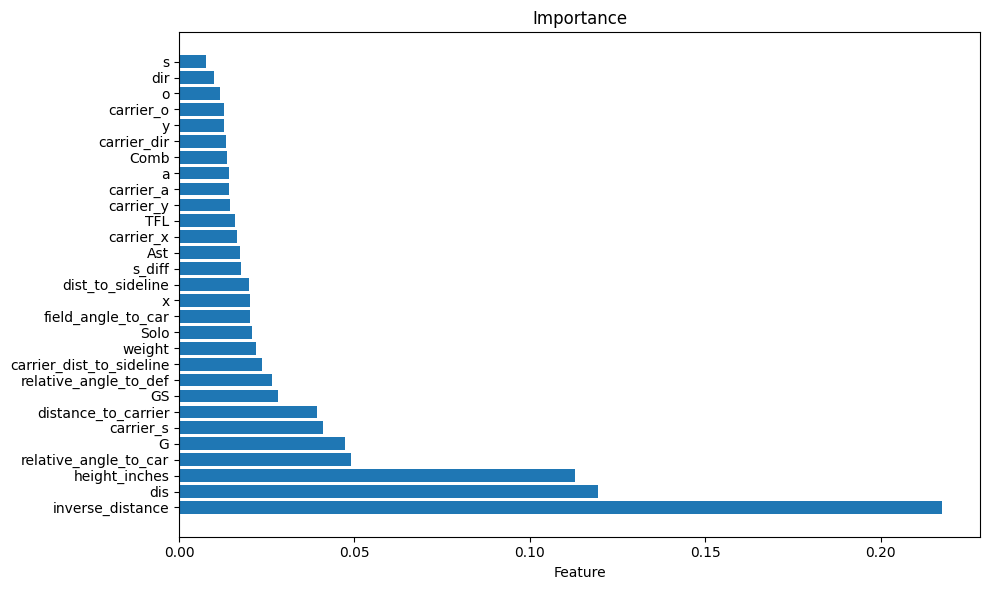

In [21]:
# View importance scores for our features
# Calculate feature importances
importance_scores = model.feature_importances_
feature_names = X.columns
feature_importance = list(zip(feature_names, importance_scores))
feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)
for feature, score in feature_importance:
    print(f"{feature}: {score}")
# Separate feature names and importance scores
features, scores = zip(*feature_importance)
# Create a bar graph
plt.figure(figsize=(10, 6))
plt.barh(range(len(features)), scores, align='center')
plt.yticks(range(len(features)), features)
plt.xlabel('Feature')
plt.title('Importance')
plt.tight_layout()
plt.show()

# Play Simulation

In [22]:
# Add position so we can identify specific positions
player_fields = ['nflId', 'position']
tracking_sim = tracking_sim.merge(players[player_fields], on='nflId', how='left')

In [23]:
# Choose a random game/play/defender for simulation. Chosen play must have a tackle occur.
# Filter to plays with tackles
game_play_combinations_with_tackle = tackles[['gameId', 'playId']][tackles['tackle_in_play_raw'] == 1].drop_duplicates()
filtered_tracking_sim = tracking_sim.merge(game_play_combinations_with_tackle, on=['gameId', 'playId'], how='inner')
# Choose a random game/play/defender
sim_choices = filtered_tracking_sim.groupby(['gameId', 'playId'])
random_group_key = random.choice(list(sim_choices.groups.keys()))
selected_gameId, selected_playId = random_group_key
# Print game and play that were chosen
print("Random gameId:", selected_gameId)
print("Random playId:", selected_playId)
# Override the game and play that were chosen (optional - I override for the presentation)
selected_gameId = 2022091900
selected_playId = 1116

Random gameId: 2022102309
Random playId: 1490


In [24]:
# Record some play information for the dashboard
game_info = games[games['gameId'] == selected_gameId]
play_info = plays[(plays['gameId'] == selected_gameId) & (plays['playId'] == selected_playId)]
selected_playDescription = play_info['playDescription'].values[0]
selected_season, selected_week, selected_homeTeamAbbr, selected_visitorTeamAbbr = game_info.loc[:, ['season', 'week', 'homeTeamAbbr', 'visitorTeamAbbr']].values[0]

In [25]:
# Create dashboard data
sim_frames = tracking_sim[(tracking_sim['gameId'] == selected_gameId) & (tracking_sim['playId'] == selected_playId)]
# Calculate min & max frames for simulation
min_frame = sim_frames['frameId'].min()
max_frame = sim_frames['frameId'].max()

In [26]:
# Use model to make tackle predictions for simulation
# Identify feature names from trained model
feature_names = model.get_booster().feature_names
# If model was calibrated, use the calibrated version, otherwise use the regular model
if brier_score > 0.01:
    subset_predicted_probabilities = calibrated_model.predict_proba(tracking_sim[feature_names])
else:
    subset_predicted_probabilities = model.predict_proba(tracking_sim[feature_names])

# Record probability predictions onto simulation data for visualization purposes
class_1_probabilities = subset_predicted_probabilities[:, 1]
proba_list = class_1_probabilities.tolist()
tracking_sim = tracking_sim.copy()
tracking_sim.loc[:, 'tackle_probability'] = np.round(proba_list, 2)
tracking_sim.loc[:, 'frameId'] = np.round(tracking_sim['frameId'].astype(float), 2)

In [27]:
# Calculate average tackle probability for each frame
# Group by 'gameId', 'playId', 'nflId', and 'frameId', and calculate the cumulative sum for 'tackle_probability'
tracking_sim['cumulative_sum'] = tracking_sim.groupby(['gameId', 'playId', 'nflId'])['tackle_probability'].cumsum()
# Calculate the average tackle probability for each frame
tracking_sim['avg_tackle_prob'] = tracking_sim['cumulative_sum'] / (tracking_sim['frameId'] - tracking_sim['ball_snap_frame'] + 1)
# Filter down main prediction dataset for simulation purposes
sim_data = tracking_sim[(tracking_sim['gameId'] == selected_gameId) & (tracking_sim['playId'] == selected_playId)]

In [28]:
# Calculate the player with the highest ATP for this play
sum_tackle_prob = sim_data[sim_data['club'] == sim_data['defensiveTeam']].groupby('nflId')['tackle_probability'].sum()
sum_tackle_prob = int(sum_tackle_prob.idxmax())
selected_nflId = sum_tackle_prob

# Identify player-specific information
player_info = players[players['nflId'] == selected_nflId]
selected_nflName = player_info.loc[:, ['displayName']].values[0].item()

In [29]:
# Setup static properties for the dashboard and plots
def dashboard():
    # Set dashboard size and quadrants
    fig = plt.figure(figsize=(12, 10.66))
    ax_field = plt.subplot2grid((3, 2), (0, 0), colspan=2, rowspan=2)
    ax_radar = plt.subplot2grid((3, 2), (2, 0), colspan=1)
    ax_tackle = plt.subplot2grid((3, 2), (2, 1), colspan=1)
    
    # Static properties - ax_field
    # Create the field
    ax_field.add_patch(patches.Rectangle((0, 0), 120, 53.3, linewidth=1, edgecolor='white', facecolor='green', zorder=0))
    # Add 10 yard lines
    for a in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]:
        ax_field.axvline(x=a, color='white', zorder=1)
    ax_field.axhline(y=0, color='white', zorder=1)
    ax_field.axhline(y=53.3, color='white', zorder=1)
    # Add numbers
    for x in range(10, 100, 10):
        if x > 50:
            ax_field.text(x + 10, 5, str(100 - x), horizontalalignment='center', fontsize=20, color='white', zorder=1)
            ax_field.text(x + 9.25, 53.3 - 5, str(100 - x), horizontalalignment='center', fontsize=20, color='white', zorder=1, rotation=180)
        else:
            ax_field.text(x + 10, 5, str(x), horizontalalignment='center', fontsize=20, color='white', zorder=1)
            ax_field.text(x + 9.25, 53.3 - 5, str(x), horizontalalignment='center', fontsize=20, color='white', zorder=1, rotation=180)
    # Add hashes
    for x in range(11, 110):
        ax_field.plot([x, x], [0.5, 0.8], color='white', zorder=1)
        ax_field.plot([x, x], [52.7, 52.4], color='white', zorder=1)
        ax_field.plot([x, x], [23, 23.66], color='white', zorder=1)
        ax_field.plot([x, x], [29.66, 30.33], color='white', zorder=1)
    # Other formatting
    ax_field.axis('off')
    ax_field.set_title(f'Week {selected_week} of {selected_season} Season, {selected_homeTeamAbbr} vs {selected_visitorTeamAbbr}\n{selected_playDescription}')
    subtitle = ax_field.text(0.512, 0.865, '', fontsize=12, transform=fig.transFigure, color='black', ha='center')
    subtitle.set_text(f'Player with highest average tackle probability (ATP): {selected_nflName}')

    # Static properties - ax_radar
    circle = plt.Circle((0, 0), 1, fill=False, color='green')
    # Remove axis boundary lines
    ax_radar.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
    ax_radar.tick_params(axis='both', which='both', length=0, labelleft=False, labelbottom=False)
    ax_radar.axis('off')
        
    # Static properties - ax_tackle
    ax_tackle.set_xlabel('Frame')
    ax_tackle.set_ylabel('%')
    ax_tackle.set_title(f'Play Analysis - {selected_nflName}')
    ax_tackle.set_xlim(min_frame, max_frame)
    ax_tackle.set_ylim(-0.01, 1)
    # Create a function to format y-axis labels as percentages
    def percentage_formatter(x, pos):
        return f'{x:.0%}'
    # Apply the formatter to the y-axis
    ax_tackle.yaxis.set_major_formatter(mtick.FuncFormatter(percentage_formatter))
    box = ax_tackle.get_position()
    ax_tackle.set_position([box.x0 - 0.05, box.y0, box.width, box.height])  # Adjust the x0 value based on your preference
    
    return fig, ax_field, ax_radar, ax_tackle

In [30]:
# Initialize the final dashboard
fig, ax_field, ax_radar, ax_tackle = dashboard()

# Format field entities that are updated every frame
offense, = ax_field.plot([], [], 'bo', markersize=3, zorder=2)
defense, = ax_field.plot([], [], 'ro', markersize=3, zorder=2)
ball_team, = ax_field.plot([], [], 'bx', markersize=6, zorder=3)
carrier_team, = ax_field.plot([], [], 'bx', markersize=3, zorder=3)
specified_defense_marker, = ax_field.plot([], [], 'kx', markersize=6, zorder=3)

# Calculate line chart data
tackle_subset = sim_data[(sim_data['gameId']==selected_gameId) & (sim_data['playId']==selected_playId) & (sim_data['nflId']==selected_nflId)].sort_values(by='frameId')
tackle_x = [round(float(value), 2) for value in tackle_subset['frameId'].tolist()]
tackle_y = [round(float(value), 2) for value in tackle_subset['tackle_probability'].tolist()]
tackle_avg = [round(float(value), 2) for value in tackle_subset['avg_tackle_prob'].tolist()]

# Format tackle probability plot
line, = ax_tackle.plot([], [], lw=2, label='tackle probability')
line_avg, = ax_tackle.plot([], [], lw=2, label='average tackle probability')
ax_tackle.legend(loc='upper left', bbox_to_anchor=(0.01, 0.85), fontsize=10)

# Initialize arrows
arrows = []
arrow_length = 2.0
arrow_orientation = 90 # Original data needs rotated 90 degrees based on current sideways field graphic.

# Format the subtitle
subtitle_tackle = ax_tackle.text(.56, 0.31, '', fontsize=11, color='black', transform=fig.transFigure)

# Function to initialize the plot
def init():
    line.set_data([], [])
    line_avg.set_data([], [])
    subtitle_tackle.set_text('')
    return line, line_avg, subtitle_tackle

# Define the update function for the dashboard
def update_field(frame, ax_field, ax_radar, ax_tackle):
    # Calculate new frame
    new_frame = sim_data[(sim_data['frameId'] == frame) & (sim_data['gameId'] == selected_gameId) & (sim_data['playId'] == selected_playId)]
    
    # Update the new variables for this frame
    relative_angle_to_car = new_frame.loc[new_frame['nflId'] == selected_nflId, 'relative_angle_to_car'].values[0]
    tackle_prob = new_frame.loc[new_frame['nflId'] == selected_nflId, 'tackle_probability'].values[0]
    avg_tackle_prob = new_frame.loc[new_frame['nflId'] == selected_nflId, 'avg_tackle_prob'].values[0]
    
    # Update tackle plot
    line.set_data(tackle_x[:frame - 5], tackle_y[:frame -5])
    line_avg.set_data(tackle_x[:frame - 5], tackle_avg[:frame -5])
    
    # Update radar plot
    ax_radar.clear()
    ax_radar.plot(0, 0, 'bx', markersize=8)
    ax_radar.add_patch(patches.FancyArrowPatch((0, 0), (0, 0.6), arrowstyle='->', color='black', linewidth=1.0))
    ax_radar.plot(0, 0.6, 'k-^', markersize=6)
    ax_radar.set_title(f'Relative Angle of \n{selected_nflName} to Carrier:\n{int(relative_angle_to_car)} degrees', y=0.8)
    circle = plt.Circle((0, 0), 1, fill=False, color='green')
    ax_radar.add_patch(circle)
    angle_radians = np.radians(relative_angle_to_car)
    x = np.sin(angle_radians)
    y = np.cos(angle_radians)
    ax_radar.plot(x, y, 'kx', markersize=6)
    ax_radar.set_xlim(-3, 3)
    ax_radar.set_ylim(-2.0, 2.0)

    # Update field plot
    offense_data = new_frame[(new_frame['club'] == new_frame['possessionTeam']) & (new_frame['current_carrier'] != 1)][['x', 'y']]
    defense_data = new_frame[(new_frame['club'] != new_frame['possessionTeam']) & (new_frame['displayName'] != 'football') &  (new_frame['nflId'] != selected_nflId)][['x', 'y']]
    ball_team_data = new_frame[new_frame['displayName'] == 'football'][['x', 'y']]
    carrier_team_data = new_frame[(new_frame['current_carrier'] == 1)]
    def_player_data = new_frame[(new_frame['nflId'] == selected_nflId)][['x', 'y']]
    offense.set_data(offense_data['x'], offense_data['y'])
    defense.set_data(defense_data['x'], defense_data['y'])
    ball_team.set_data(ball_team_data['x'], ball_team_data['y'])
    carrier_team.set_data(carrier_team_data['x'], carrier_team_data['y'])
    specified_defense_marker.set_data(def_player_data['x'], def_player_data['y'])
    
    # Update arrows
    for arrow in arrows:
        arrow.remove()
    arrows.clear()
    
    for player in [def_player_data, carrier_team_data]:
        for i, data in player.iterrows():
            x, y, orientation = data['x'], data['y'], new_frame.loc[i, 'dir'] + arrow_orientation
            dx = -arrow_length * np.cos(np.radians(orientation))
            dy = arrow_length * np.sin(np.radians(orientation))
            # Create an arrow for the player
            arrow = ax_field.arrow(x, y, dx, dy, head_width=.6, head_length=0.6, fc='black', ec='black', lw=2, zorder=3)
            arrows.append(arrow)

    subtitle_tackle.set_text(f'Frame: {frame}')

    return offense, defense, specified_defense_marker, ball_team, carrier_team, subtitle_tackle, line, line_avg

# Create a FuncAnimation for the football field animation
anim_field = FuncAnimation(fig, update_field, frames=range(int(min_frame), int(max_frame + 1)), fargs=(ax_field, ax_radar, ax_tackle), interval=85)

# Display the football field animation
anim_field.save('line_animation.mp4', writer='ffmpeg', fps=10)
plt.close()
HTML(anim_field.to_jshtml())

# Other Visualizations

In [31]:
# Rank linebacker importance based on tackle probabilities
tackle_sim_ranking = sim_data[sim_data['club'] == sim_data['defensiveTeam']][['gameId', 'playId', 'nflId', 'displayName', 'frameId', 'tackle_probability', 'avg_tackle_prob', 'cumulative_sum', 'position']]
tackle_sim_ranking = tackle_sim_ranking[tackle_sim_ranking['position'].str.contains('LB', na=False)]
tackle_sim_ranking['tackle_probability'] = tackle_sim_ranking['tackle_probability'].round(2)
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 5))
fig.subplots_adjust(left=0.15)
# Get a unique list of 'nflId' for y-axis labels
nflIds = [str(nflId) for nflId in tackle_sim_ranking['nflId'].unique()]
# Define the update function for animation
def update(frame):
    ax.clear()
    # Filter data for the current frame
    data_frame = tackle_sim_ranking[tackle_sim_ranking['frameId'] == frame]
    # Various formatting
    sorted_data = data_frame.sort_values(by='displayName', ascending=True)
    y_order = sorted_data['displayName'].astype(str)
    ax.barh(y_order, sorted_data['avg_tackle_prob'], height=0.5, color='orange')
    ax.set_xlabel('Average Tackle Probability Over Time')
    ax.set_title(f'Average Tackle Probability (ATP) - All Linebackers\nFrame {frame}')
    ax.set_xlim(0, 1)
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0%}'))
    ax.tick_params(axis='y', labelsize=10)
# Create the animation
frames = tackle_sim_ranking['frameId'].unique()
ani = FuncAnimation(fig, update, frames=frames, repeat=False, blit=False, interval=90)
ani.save('ranking.mp4', writer='ffmpeg', fps=20)
plt.close()
HTML(ani.to_jshtml())

# Average Tackle Probabilities (ATPs)

In [32]:
# Calculate the ATP scores for all linebackers
# Group by 'gameId', 'nflId', and 'playId', and select rows with the max 'frameId'
seasonal_atps = tracking_sim.loc[tracking_sim.groupby(['gameId', 'nflId', 'playId'])['frameId'].idxmax()]
seasonal_atps = seasonal_atps[seasonal_atps['position'].str.contains('LB')]
# Now seasonal_atps contains the final ATP for every linebacker on every play
columns_to_keep = ['nflId', 'displayName', 'position', 'avg_tackle_prob']
seasonal_atps.drop(columns=seasonal_atps.columns.difference(columns_to_keep), inplace=True)
# Average out ATPs for each player across weeks 1-9, 2022
seasonal_atps = seasonal_atps.groupby('nflId').agg(
    displayName=('displayName', 'first'),
    position=('position', 'first'),
    atp_count=('avg_tackle_prob', 'size'),
    avg_tackle_prob=('avg_tackle_prob', 'mean')
).reset_index()
# Sort all linebackers by their ATP scores
seasonal_atps_ranked = seasonal_atps.sort_values(by='avg_tackle_prob', ascending=False)

In [33]:
# Check for any players that are duplicated or have the same name in PFR
duplicate_display_names = pff_stats_2022[pff_stats_2022.duplicated('displayName', keep=False)]['displayName'].unique()
print(duplicate_display_names)

['Michael Carter' 'Lamar Jackson' 'Aaron Brewer' 'Connor McGovern']


In [34]:
# Merge in traditional PFR 2022 stats to ATP rankings so we can review how the rankings compare
atp_ranking_validation = seasonal_atps_ranked.merge(pff_stats_2022[['displayName', 'Comb▼', 'Pos']], on=['displayName'], how='left')
# Very small # of players where the name in PFR still does not match the name in the NFL data.
# All of them have <100 snaps so just removing these players since their rankings aren't reliable.
atp_ranking_validation = atp_ranking_validation[~atp_ranking_validation['Pos'].isna()]
# 10 players have conflicting information where they are a LB in NFL data but not in the PFR data. Removing these to ensure we only have LBs in our ranking.
atp_ranking_validation = atp_ranking_validation[atp_ranking_validation['Pos'].str.contains('LB')]

In [35]:
# Did any of these duplicated names affect our dataset? If this list is empty after merging, then we're fine.
duplicate_display_names = atp_ranking_validation[atp_ranking_validation.duplicated('displayName', keep=False)]['displayName'].unique()
print(duplicate_display_names)

[]


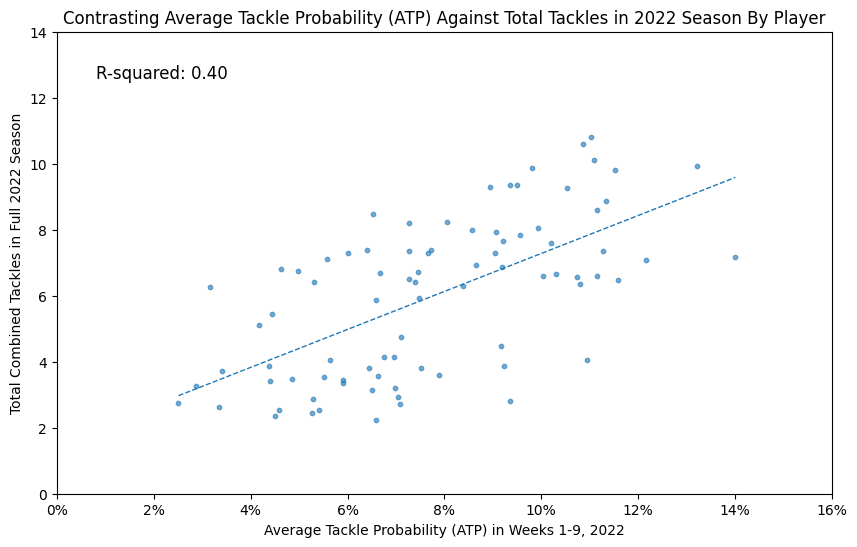

In [36]:
# 100+ Snaps Comparison
# Calculate R-Squared
atp_ranking_validation_plot = atp_ranking_validation[atp_ranking_validation['atp_count'] >= 100]
atps = atp_ranking_validation_plot['avg_tackle_prob']
combs = atp_ranking_validation_plot['Comb▼']
atps = sm.add_constant(atps)
R2_model = sm.OLS(combs, atps).fit()
r_squared = R2_model.rsquared.round(2)
# Plot ATP vs Total 2022 Combined Tackles
plt.figure(figsize=(10, 6))
sns.regplot(x='avg_tackle_prob', y='Comb▼', data=atp_ranking_validation_plot, scatter_kws={'s': 10, 'alpha': 0.6}, label='Scatter Plot', ci=None, line_kws={'linestyle': '--', 'linewidth': 1.0})
plt.xlabel('Average Tackle Probability (ATP) in Weeks 1-9, 2022')
plt.ylabel('Total Combined Tackles in Full 2022 Season')
plt.title('Contrasting Average Tackle Probability (ATP) Against Total Tackles in 2022 Season By Player')
plt.annotate(f'R-squared: {r_squared:.2f}', xy=(0.05, 0.9), xycoords='axes fraction', fontsize=12, color='black')
plt.ylim(0, 14)
plt.xlim(0, 0.16)
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0%}'))
plt.show()

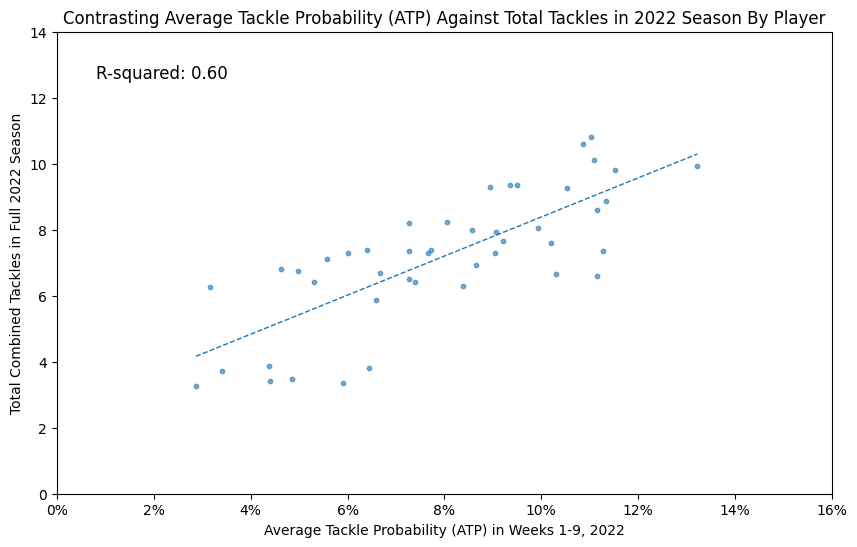

In [37]:
# 150+ Snaps Comparison
# Calculate R-Squared
atp_ranking_validation_plot = atp_ranking_validation[atp_ranking_validation['atp_count'] >= 150]
atps = atp_ranking_validation_plot['avg_tackle_prob']
combs = atp_ranking_validation_plot['Comb▼']
atps = sm.add_constant(atps)
R2_model = sm.OLS(combs, atps).fit()
r_squared = R2_model.rsquared.round(2)
# Plot ATP vs Total 2022 Combined Tackles
plt.figure(figsize=(10, 6))
sns.regplot(x='avg_tackle_prob', y='Comb▼', data=atp_ranking_validation_plot, scatter_kws={'s': 10, 'alpha': 0.6}, label='Scatter Plot', ci=None, line_kws={'linestyle': '--', 'linewidth': 1.0})
plt.xlabel('Average Tackle Probability (ATP) in Weeks 1-9, 2022')
plt.ylabel('Total Combined Tackles in Full 2022 Season')
plt.title('Contrasting Average Tackle Probability (ATP) Against Total Tackles in 2022 Season By Player')
plt.annotate(f'R-squared: {r_squared:.2f}', xy=(0.05, 0.9), xycoords='axes fraction', fontsize=12, color='black')
plt.ylim(0, 14)
plt.xlim(0, 0.16)
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0%}'))
plt.show()

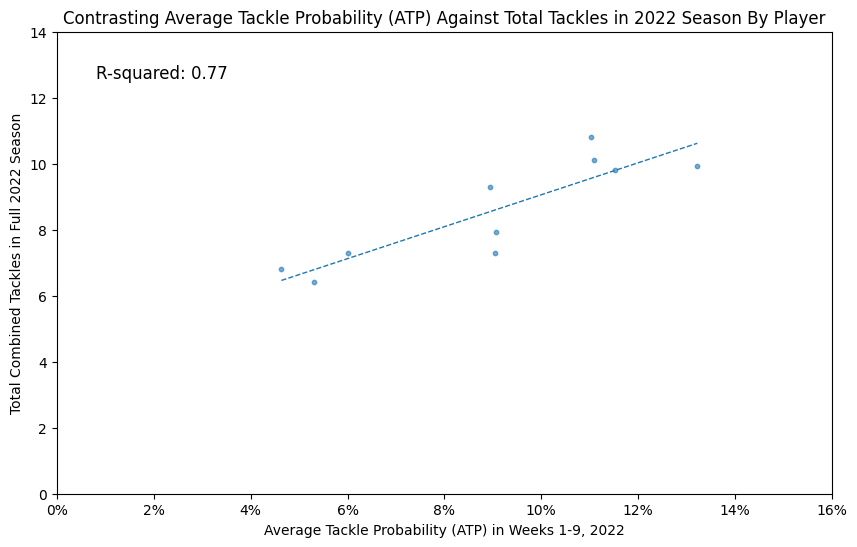

In [38]:
# 200+ Snaps Comparison
# Calculate R-Squared
atp_ranking_validation_plot = atp_ranking_validation[atp_ranking_validation['atp_count'] >= 200]
atps = atp_ranking_validation_plot['avg_tackle_prob']
combs = atp_ranking_validation_plot['Comb▼']
atps = sm.add_constant(atps)
R2_model = sm.OLS(combs, atps).fit()
r_squared = R2_model.rsquared.round(2)
# Plot ATP vs Total 2022 Combined Tackles
plt.figure(figsize=(10, 6))
sns.regplot(x='avg_tackle_prob', y='Comb▼', data=atp_ranking_validation_plot, scatter_kws={'s': 10, 'alpha': 0.6}, label='Scatter Plot', ci=None, line_kws={'linestyle': '--', 'linewidth': 1.0})
plt.xlabel('Average Tackle Probability (ATP) in Weeks 1-9, 2022')
plt.ylabel('Total Combined Tackles in Full 2022 Season')
plt.title('Contrasting Average Tackle Probability (ATP) Against Total Tackles in 2022 Season By Player')
plt.annotate(f'R-squared: {r_squared:.2f}', xy=(0.05, 0.9), xycoords='axes fraction', fontsize=12, color='black')
plt.ylim(0, 14)
plt.xlim(0, 0.16)
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0%}'))
plt.show()

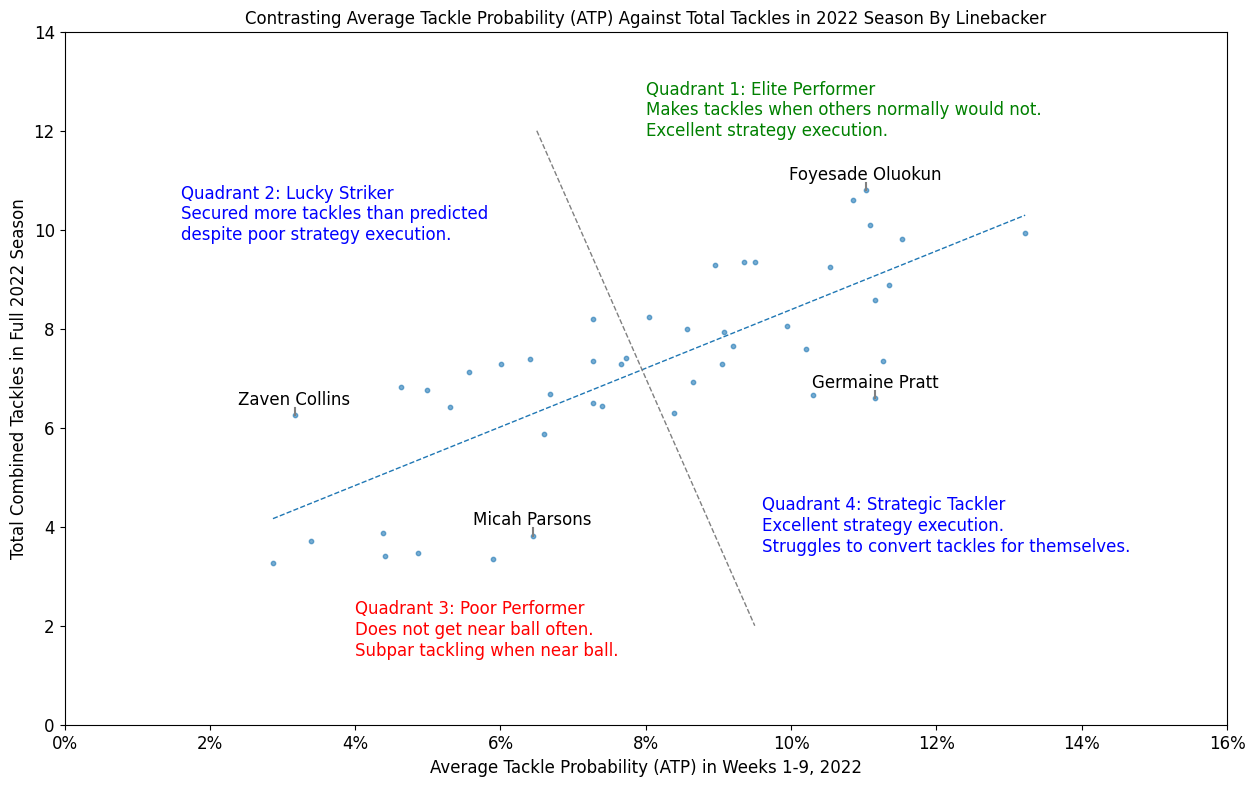

In [39]:
# 150+ Snaps Comparison w/ Quadrant Analysis
# Calculate R-Squared
atp_ranking_validation_plot = atp_ranking_validation[atp_ranking_validation['atp_count'] >= 150]
atps = atp_ranking_validation_plot['avg_tackle_prob']
combs = atp_ranking_validation_plot['Comb▼']
atps = sm.add_constant(atps)
R2_model = sm.OLS(combs, atps).fit()
r_squared = R2_model.rsquared.round(2)
# Create second line to show quadrants
x1 = .065
x2 = 0.095
y1 = 12
y2 = 2
# Plot ATP vs Total 2022 Combined Tackles
plt.figure(figsize=(15, 9))
sns.regplot(x='avg_tackle_prob', y='Comb▼', data=atp_ranking_validation_plot, scatter_kws={'s': 10, 'alpha': 0.6}, label='Scatter Plot', ci=None, line_kws={'linestyle': '--', 'linewidth': 1.0})
plt.xlabel('Average Tackle Probability (ATP) in Weeks 1-9, 2022', fontsize=12)
plt.ylabel('Total Combined Tackles in Full 2022 Season', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Contrasting Average Tackle Probability (ATP) Against Total Tackles in 2022 Season By Linebacker')
plt.ylim(0, 14)
plt.xlim(0, 0.16)
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0%}'))
# Manually choose some players to identify for explanation purposes
chosen_names = ['Foyesade Oluokun', 'Zaven Collins', 'Germaine Pratt', 'Micah Parsons']
for name in chosen_names:
    data_point = atp_ranking_validation_plot[atp_ranking_validation_plot['displayName'] == name]
    if not data_point.empty:
        x = data_point['avg_tackle_prob'].iloc[0]
        y = data_point['Comb▼'].iloc[0]
        plt.text(x, y + 0.5, name, fontsize=12, ha='center', va='top')  # Adjusted va parameter
        plt.plot([x, x], [y, y + 0.15], color='gray', linestyle='-')  # Leader line
# Plot perpendicular line
plt.plot([x1, x2], [y1, y2], color='gray', linestyle='--', linewidth=1.0, label='Perpendicular Trendline')
# Annotate quadrants
plt.annotate('Quadrant 2: Lucky Striker\nSecured more tackles than predicted\ndespite poor strategy execution.', xy=(0.1, 0.7), xycoords='axes fraction', fontsize=12, color='blue')
plt.annotate('Quadrant 3: Poor Performer\nDoes not get near ball often.\nSubpar tackling when near ball.', xy=(0.25, 0.1), xycoords='axes fraction', fontsize=12, color='red')
plt.annotate('Quadrant 1: Elite Performer\nMakes tackles when others normally would not.\nExcellent strategy execution.', xy=(0.5, 0.85), xycoords='axes fraction', fontsize=12, color='green')
plt.annotate('Quadrant 4: Strategic Tackler\nExcellent strategy execution.\nStruggles to convert tackles for themselves.', xy=(0.60, 0.25), xycoords='axes fraction', fontsize=12, color='blue')
plt.show()

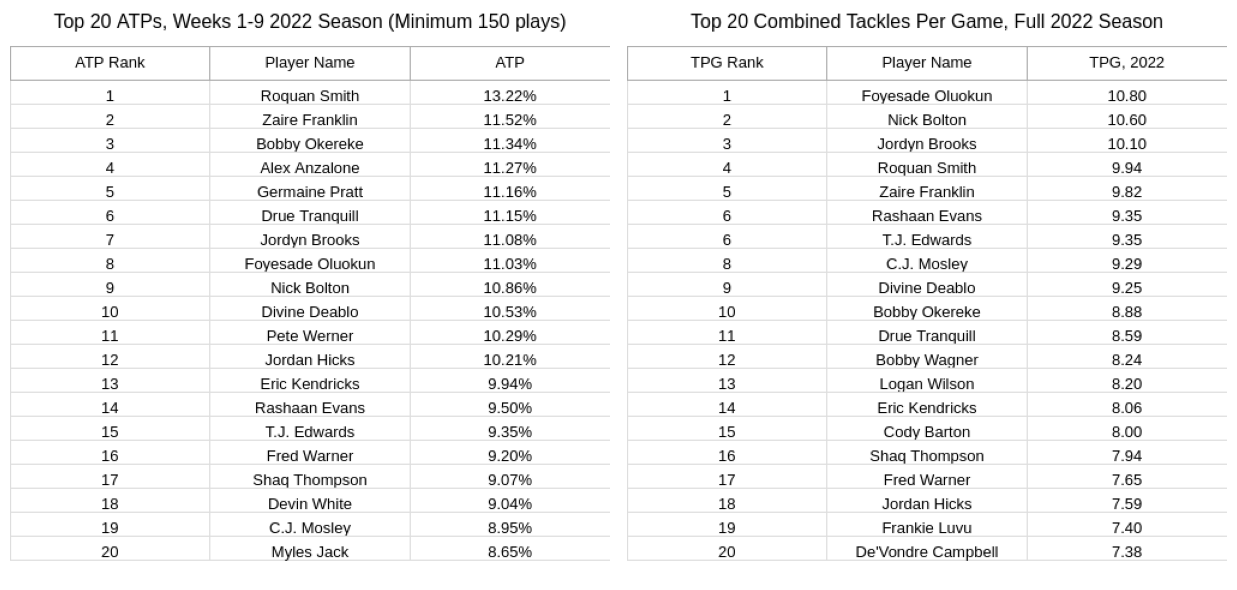

In [40]:
size = 13
figure_width= 500

# Assuming rank_table is your DataFrame
rank_table = atp_ranking_validation[atp_ranking_validation['atp_count'] >= 150]
rank_table = rank_table.sort_values(by='avg_tackle_prob', ascending=False)

# Create 'atp_rank' field
rank_table['atp_rank'] = rank_table['avg_tackle_prob'].rank(ascending=False, method='min')

# Format 'avg_tackle_prob' as a percentage with two decimal places
rank_table['ATP'] = rank_table['avg_tackle_prob'].apply(lambda x: f'{x:.2%}')

rank_table_atps = rank_table.nlargest(20, 'avg_tackle_prob')

# Plotting atp
fig_atp = go.Figure(data=[go.Table(
    header=dict(values=['ATP Rank', 'Player Name', 'ATP'],
               fill_color=[['#FFFFFF', '#FFFFFF', '#FFFFFF']],
               line_color=[['#AEAEAE', '#AEAEAE', '#AEAEAE']],
               font=dict(color='black', size = size),
               ),
    cells=dict(values=[rank_table_atps['atp_rank'], rank_table_atps['displayName'], rank_table_atps['ATP']],
               fill_color=[['#FFFFFF', '#FFFFFF', '#FFFFFF']],
               line_color=[['#DEDEDE', '#DEDEDE', '#DEDEDE']],
               font=dict(color='black', size = size),
               ))])

fig_atp.update_layout(title='Top 20 ATPs, Weeks 1-9 2022 Season (Minimum 150 plays)',
                      title_font_size=16,
                      title_font_color='black',
                      title_x=0.5,  # Adjust the x position for center alignment
                      height=475,  # Adjust the height as needed
                      margin=dict(l=0, r=0, b=0, t=30),  # Adjust margins as needed
                      width=figure_width,
                      showlegend=False)  # Optional: Hide legend if not needed

# Creating a second figure (fig_pff) with sorted DataFrame
rank_table = rank_table.sort_values(by='Comb▼', ascending=False)

# Create 'tpg_rank' field
rank_table['tpg_rank'] = rank_table['Comb▼'].rank(ascending=False, method='min')

rank_table_tpgs = rank_table.nlargest(20, 'Comb▼')

# Format 'Comb▼' to show 2 decimal places
rank_table_tpgs['Comb▼'] = rank_table_tpgs['Comb▼'].apply(lambda x: '{:.2f}'.format(x))

fig_pff = go.Figure(data=[go.Table(
    header=dict(values=['TPG Rank', 'Player Name', 'TPG, 2022'],
               fill_color=[['#FFFFFF', '#FFFFFF', '#FFFFFF']],
               line_color=[['#AEAEAE', '#AEAEAE', '#AEAEAE']],
               font=dict(color='black', size = size),
               ),
    cells=dict(values=[rank_table_tpgs['tpg_rank'], rank_table_tpgs['displayName'], rank_table_tpgs['Comb▼']],
               fill_color=[['#FFFFFF', '#FFFFFF', '#FFFFFF']],
               line_color=[['#DEDEDE', '#DEDEDE', '#DEDEDE']],
               font=dict(color='black', size = size),
               ))])

fig_pff.update_layout(title='Top 20 Combined Tackles Per Game, Full 2022 Season',
                      title_font_size=16,
                      title_font_color='black',
                      title_x=0.5,
                      height=475,
                      margin=dict(l=0, r=0, b=0, t=30),
                      width=figure_width,
                      showlegend=False)

# Save the figures
fig_atp.write_image("atp.png")
fig_pff.write_image("tpg.png")

# Combine tables
atp_image = plt.imread("atp.png")
tpg_image = plt.imread("tpg.png")

fig_combined, ax_combined = plt.subplots(1, 2, figsize=(12.5, 6))
ax_combined[0].imshow(atp_image)
ax_combined[0].axis('off')
ax_combined[1].imshow(tpg_image)
ax_combined[1].axis('off')
plt.tight_layout()
plt.savefig("combined.png")
plt.show()